In [1]:
# necessary modules 
import argparse
import zipfile
import os
import cv2
import time
import copy
import pandas as pd
import numpy as np
from pandas.core.common import index_labels_to_array
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import *
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import PIL.Image as Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/MAMI DATASET/training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/MAMI DATASET/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/', pwd=b'*MaMiSemEval2022!')

### Data preprocessing

In [5]:
import pandas as pd
data = pd.read_csv('/content/data/TRAINING/training.csv', sep='\t')
data.head(1)

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip


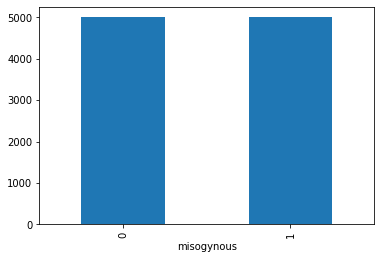

In [130]:
# label distibution in the training set
data.groupby(['misogynous']).size().plot.bar()

In [6]:
# read test labels from provided text file
test_labels = pd.read_csv('/content/drive/MyDrive/MAMI DATASET/test_labels.txt', sep='\t', header=None, names=['file_name', "misogynous",	"shaming",	"stereotype",	"objectification",	"violence"])

In [7]:
test_labels = test_labels[['file_name', 'misogynous']]
test_labels.to_csv('/content/data/test/labels.csv', index=None, sep='\t')

In [8]:
train_labels = pd.read_csv('/content/data/TRAINING/training.csv', sep='\t')
train_labels = train_labels[['file_name', 'misogynous']]
train_labels.to_csv('/content/data/TRAINING/labels.csv', index=None, sep='\t')

In [10]:
train_labels = pd.read_csv('/content/data/TRAINING/labels.csv', sep='\t')
train_labels.head(2)

,file_name,misogynous
0,1.jpg,0
1,10.jpg,1


In [9]:
test_labels = pd.read_csv('/content/data/test/labels.csv', sep='\t')
test_labels.head(2)

,file_name,misogynous
0,15236.jpg,0
1,15805.jpg,1


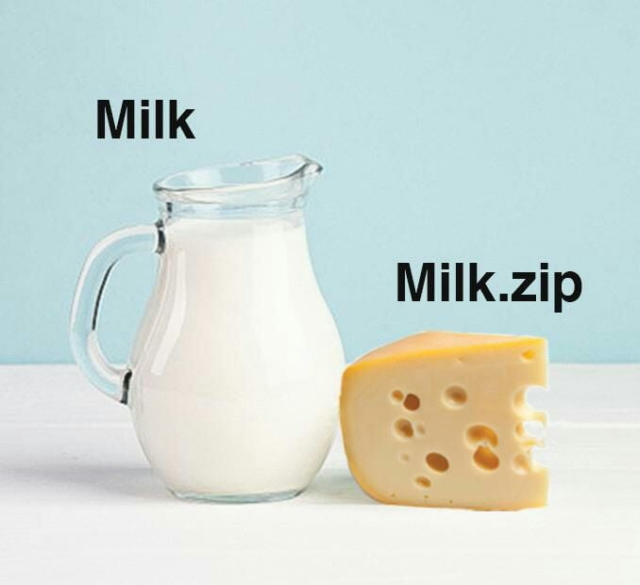

In [11]:
# visualize one of the images 
from IPython.display import Image
Image('/content/data/TRAINING/1.jpg')

In [12]:
class MamiDataset(Dataset):
  '''
  Preprocess the image dataset.

  Input:
    csv: csv file with file names and corresponding labels
    img_folder: folder containing images
    transform: torchvision.transforms

  Output:
    tuples of transformed images and their labels
  '''
  def __init__(self, csv, img_folder, transform):
    self.csv = csv
    self.transform = transform
    self.img_folder = img_folder
    
    self.image_names = self.csv[:]['file_name']
    self.labels=np.array(self.csv.drop(['file_name'], axis=1))
  
  #The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.image_names)

  def __getitem__(self,idx):
    
    image = cv2.imread((self.img_folder+self.image_names).iloc[idx])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    
    image = self.transform(image)
    targets = self.labels[idx]
  

    return (image, targets)

In [70]:
import torchvision.transforms as transform
batch_size = 16

train_transforms = transform.Compose([
        transform.ToPILImage(),
        transform.RandomRotation(25),
        transform.Resize((256,256)),
        transform.CenterCrop(224),
        # transform.RandomHorizontalFlip(p=0.7),
        transform.ColorJitter(),
        transform.ToTensor()])

test_transforms = transform.Compose([transform.ToPILImage(),
                                     transform.Resize((256,256)),
                                     transform.CenterCrop(224),
                                     transform.ToTensor()])

train_dataset = MamiDataset(train_labels, '/content/data/TRAINING/', train_transforms)
test_dataset = MamiDataset(test_labels, '/content/data/test/', test_transforms)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


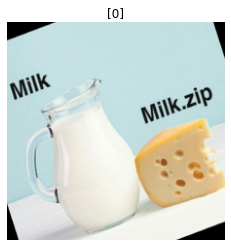

In [71]:
temp_img, temp_lab = train_dataset[0]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(temp_lab)
plt.axis('off')
plt.show()

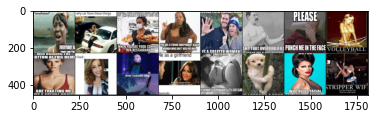

In [72]:
def imshow(inp, title=None):
    '''
    Visualize a batch of training data
    '''
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


# Get a batch of training data
images = next(iter(test_dataloader))

# Make a grid from batch
output = torchvision.utils.make_grid(images[0])

imshow(output)

In [73]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


In [74]:
# check if GPU is available 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [81]:
# load the pretrained model, send it to cuda
net = models.wide_resnet50_2(pretrained=True)
net = net.cuda() if device else net


num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 256) 
# above we should have set the number of classes to 2, but for some reason 
# the accuracy is much better with 256
net.fc = net.fc.cuda() if device else net.fc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [82]:
# define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
# training loop

n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        target_ = target_.reshape(-1)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
            
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            target_t = target_t.reshape(-1)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            checkpoint = {
            'epoch': epoch + 1,
            'valid_losstarget = target.reshape(-1)_min': val_loss,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),}
            torch.save(checkpoint, f'resnet_{val_acc[-1]}.pt')
            print('Improvement-Detected, save-model')
    net.train()

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy ")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

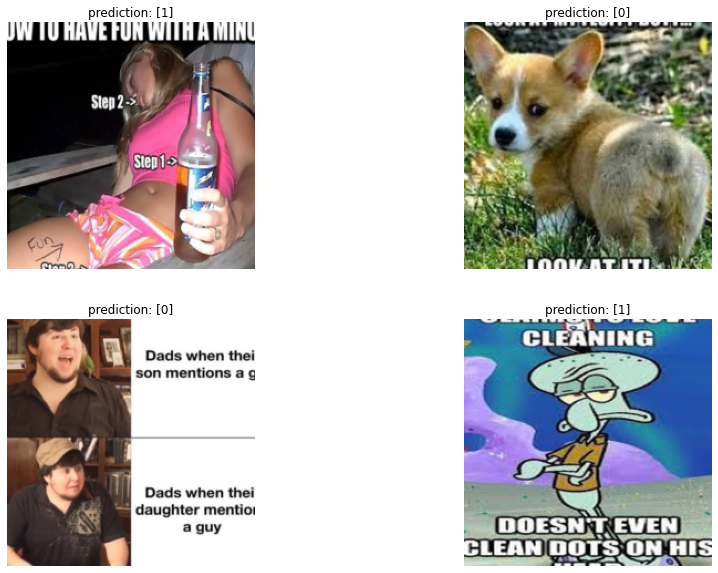

In [155]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('prediction: {}'.format(test_dataset.labels[preds[j]]))
            inputs = inputs.cpu() 
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()

### Loading fine-tuned model

In [134]:
# replicate the original model
net = models.wide_resnet50_2(pretrained=True)
net = net.cuda() if device else net

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 256)
net.fc = net.fc.cuda() if device else net.fc

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [135]:
# path to the checkpoint
ckp_path = "/content/drive/MyDrive/anlp/wide_resnet.pt"

In [146]:
trained_model = torch.load(ckp_path)
net.load_state_dict(trained_model)

valid_loss_min = np.Inf
val_loss = []
val_acc = []
batch_loss = 0
total_t = 0
correct_t = 0

with torch.no_grad():
  net.eval()
  for data_t, target_t in (test_dataloader):
    data_t, target_t = data_t.to(device), target_t.to(device)
    outputs_t = net(data_t)
    target_t = target_t.reshape(-1)
    loss_t = criterion(outputs_t, target_t)
    batch_loss += loss_t.item()
    _, pred_t = torch.max(outputs_t, dim=1)
    correct_t += torch.sum(pred_t==target_t).item()
    total_t += target_t.size(0)
    val_acc.append(100 * correct_t/total_t)
    val_loss.append(batch_loss/len(test_dataloader))
    network_learned = batch_loss < valid_loss_min
  print(f'test loss: {np.mean(val_loss):.4f}, test acc: {(100 * correct_t/total_t):.4f}\n')

test loss: 1.1825, test acc: 65.8000



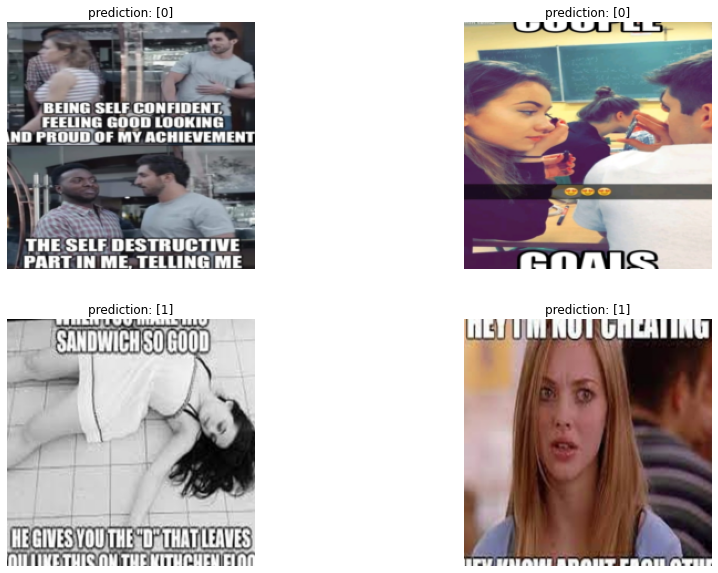

In [157]:
visualize_model(net)